            Weekly_Sales
Date                    
2010-02-05    1643690.90
2010-02-12    1641957.44
2010-02-19    1611968.17
2010-02-26    1409727.59
2010-03-05    1554806.68


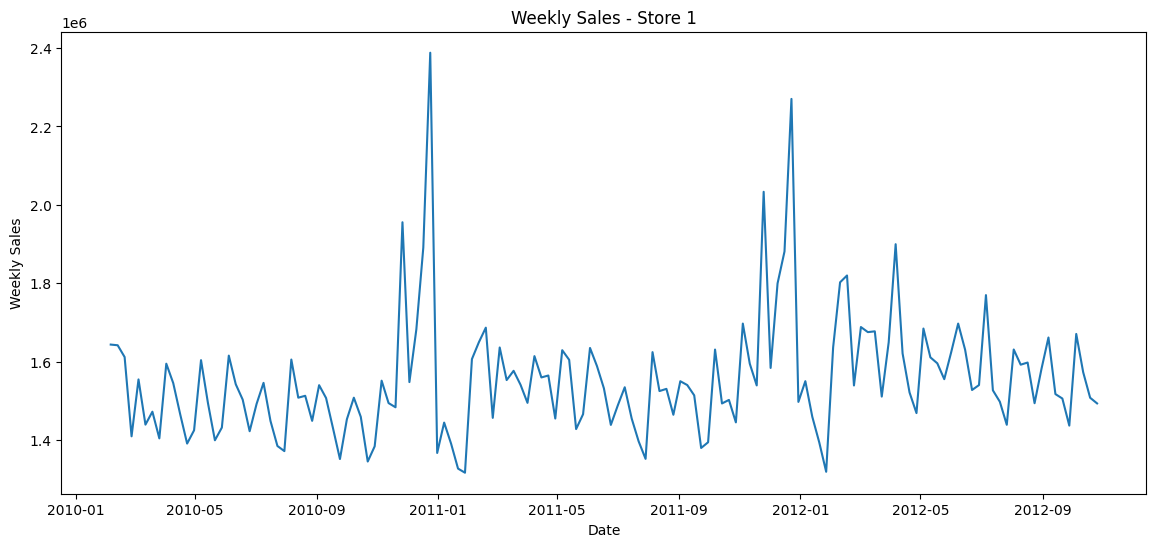

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("C:/Data_projects/Project_Walmart/Walmart.csv")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst = True)

# Sort data
df = df.sort_values(['Store', 'Date'])

# Select one store (example: Store 1)
store_df = df[df['Store'] == 1][['Date', 'Weekly_Sales']]
store_df.set_index('Date', inplace=True)
print(store_df.head())

# Plot
plt.figure(figsize=(14,6))   # wider x-axis
plt.plot(store_df.index, store_df['Weekly_Sales'])
plt.title("Weekly Sales - Store 1")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

result = adfuller(store_df['Weekly_Sales'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -5.102186145192286
p-value: 1.3877788330759535e-05


In [3]:
from statsmodels.tsa.arima.model import ARIMA

store_df = store_df.asfreq('W-FRI')

train_size = int(len(store_df) * 0.8)
train = store_df.iloc[:train_size]
test = store_df.iloc[train_size:]

model = ARIMA(train['Weekly_Sales'], order=(1,1,1))
model_fit = model.fit()

arima_forecast = model_fit.forecast(steps=len(test))


ARIMA RMSE: 122601.6277454125


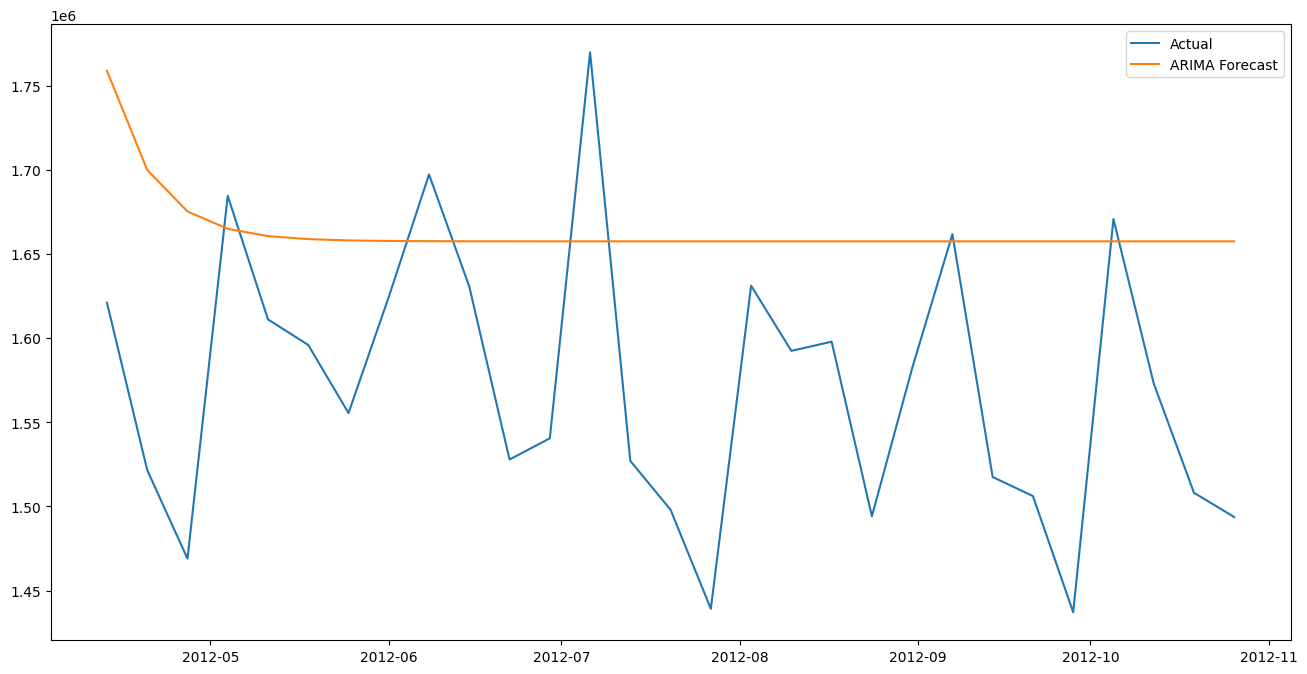

In [4]:
from sklearn.metrics import mean_squared_error

rmse_arima = np.sqrt(mean_squared_error(test['Weekly_Sales'], arima_forecast))
print("ARIMA RMSE:", rmse_arima)

plt.figure(figsize=(16,8))
plt.plot(test.index, test['Weekly_Sales'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

In [5]:
import numpy as np

rmse = 122601.63
mean_sales = store_df['Weekly_Sales'].mean()

print("RMSE %:", (rmse / mean_sales) * 100)

RMSE %: 7.883008843572885


In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# ARIMA RMSE
arima_rmse = np.sqrt(
    mean_squared_error(test['Weekly_Sales'], arima_forecast)
)

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train['Weekly_Sales'],
    order=(1,1,1),
    seasonal_order=(1,1,1,52)
)

model_fit = model.fit()
sarima_forecast = model_fit.forecast(steps=len(test))


C:\Users\Gayatri V S\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Gayatri V S\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np
sarima_forecast = pd.Series(sarima_forecast, index=test.index)
rmse = np.sqrt(mean_squared_error(test['Weekly_Sales'], sarima_forecast))
print("SARIMA RMSE:", rmse)
rmse_percent = (rmse / test['Weekly_Sales'].mean()) * 100
print("SARIMA RMSE %:", rmse_percent)


SARIMA RMSE: 209926.26862310327
SARIMA RMSE %: 13.3568370779996


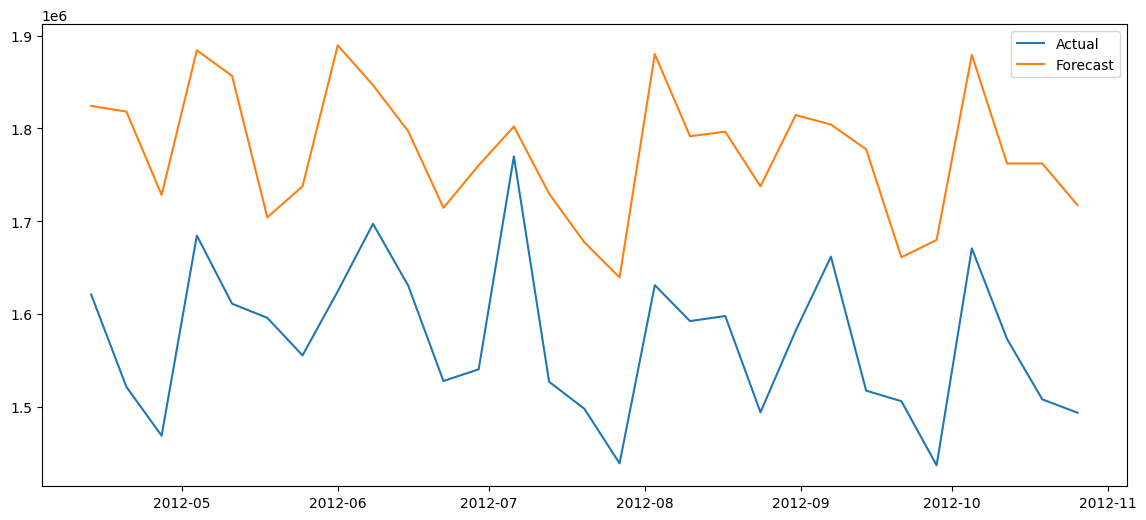

In [12]:
plt.figure(figsize=(14,6))
plt.plot(test.index, test['Weekly_Sales'], label='Actual')
plt.plot(test.index, sarima_forecast, label='Forecast')
plt.legend()
plt.show()


In [13]:
baseline = test['Weekly_Sales'].mean()


In [14]:
arima_rmse_percent = (arima_rmse / baseline) * 100
sarima_rmse_percent = (sarima_rmse / baseline) * 100

print("ARIMA RMSE % :", arima_rmse_percent)
print("SARIMA RMSE %:", sarima_rmse_percent)


ARIMA RMSE % : 7.800691061836979
SARIMA RMSE %: 13.3568370779996


In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Use original sales (NOT differenced)
data = store_df[['Weekly_Sales']].values

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, window_size=4):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 4
X, y = create_sequences(data_scaled, window_size)

# Train–test split
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test  = X[train_size:]
y_train = y[:train_size]
y_test  = y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

# Predict
y_pred = model.predict(X_test)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
rmse_lstm_percent = (rmse_lstm / np.mean(y_test_inv)) * 100


C:\Users\Gayatri V S\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0719
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0312
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0250
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0246
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0241
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0240
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0239
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0237
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0236
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0235
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0234
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0234
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0235
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232
Epoch 16/50
14/14 ━

In [16]:
print("LSTM RMSE:", rmse_lstm)
print("LSTM RMSE %:", rmse_lstm_percent)

LSTM RMSE: 92833.03923276378
LSTM RMSE %: 5.913257071137886
